# 基于K线形态锤子线的趋势跟踪策略

### 1.基本原理
1.1 K线部位定义：
实体：某一根K线开盘价和收盘价之间部分;
上影线：某一根K线最高价到实体上端的部分;
下影线：某一根K线最低价到实体下端的部分;

1.2 锤子线定义
实体处于整个价格区间上端，实体颜色本身不影响;
下影线长度至少达到实体高度的2倍;
上影线很短;

1.3 策略原理

在下跌过程中，当某一日出现锤子线，意味着当天行情先继续下跌后出现大幅反弹，行情可能由此反转; 由此以观察期均线识别趋势下跌，以下跌趋势中出现锤子线作为开仓信号;
采用移动止损方式进行止损构建此策略;

1.4 止损条件

当天最低价 < max(均价-观察期内一定倍数的标准差，开仓价-开仓时标准差）;

1.5 形态要点：

在出现锤头线（锤子线）之前，股价需经过一段时间的下跌后，处于下跌趋势中，此时出现此形态才具有参考意义；
锤头实体越小，下影线越长，止跌作用就越明显，参考价值越大；

## 策略实现

### 2.1 收集并计算所需数据

In [1]:
import pandas as pd
import numpy as np
import tushare as ts
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

In [2]:
code = '002398' # 股票代码
body_size = 0.03 # 表示锤子实体大小上限，基准为当日开盘价，实体不能太大，波动范围限制在3%；
head_size = 0.5 # 表示锤子上影线长度上限，基准为下影线长度，上影线要短一点，不能超过下影线的的一半；
tail_size = 2 # 表示下影线与实体大小比值，下影线要大于实体两倍；
length = 10 # 表示观察期时间长短；
stoplose_trigger = 1 #  表示当价格偏离均线满足几倍标准差时止损

In [3]:
data = ts.get_k_data(code, '2012-01-01', '2020-01-01')

In [5]:
data.sort_index(ascending=True, inplace=True)
data.tail()

,date,open,close,high,low,volume,code
1817,2019-12-25,5.80,5.79,5.85,5.73,47159.0,002398
1818,2019-12-26,5.82,5.90,5.94,5.79,60771.0,002398
1819,2019-12-27,5.91,5.90,5.94,5.88,51196.0,002398
1820,2019-12-30,5.90,6.02,6.04,5.87,69823.0,002398
1821,2019-12-31,6.05,6.04,6.05,5.95,75258.0,002398


In [6]:
data.reset_index(inplace=True)
data.head()

,index,date,open,close,high,low,volume,code
0,0,2012-01-04,3.521,3.396,3.605,3.392,2834.0,002398
1,1,2012-01-05,3.383,3.057,3.396,3.057,8209.0,002398
2,2,2012-01-06,3.027,3.022,3.094,2.882,9726.0,002398
3,3,2012-01-09,3.020,3.152,3.165,2.953,5365.0,002398
4,4,2012-01-10,3.152,3.292,3.325,3.152,11215.0,002398


In [7]:
data['pct_change'] = data['close'].pct_change()
data['ma'] = data['close'].rolling(length).mean()
data['std'] = data['close'].rolling(length).std()
data.tail()

,index,date,open,close,high,low,volume,code,pct_change,ma,std
1817,1817,2019-12-25,5.80,5.79,5.85,5.73,47159.0,002398,0.005208,5.786,0.040607
1818,1818,2019-12-26,5.82,5.90,5.94,5.79,60771.0,002398,0.018998,5.807,0.039735
1819,1819,2019-12-27,5.91,5.90,5.94,5.88,51196.0,002398,0.000000,5.819,0.047947
1820,1820,2019-12-30,5.90,6.02,6.04,5.87,69823.0,002398,0.020339,5.841,0.078804
1821,1821,2019-12-31,6.05,6.04,6.05,5.95,75258.0,002398,0.003322,5.862,0.100532


In [8]:
data['yes_ma'] = data['ma'].shift(1)
data['yes_std'] = data['std'].shift(1)

### 3.2 识别锤子形态

In [9]:
data['body'] = abs(data['open'] - data['close'])
data['head'] = data['high'] - data[['open','close']].max(axis = 1)
data['tail'] = data[['open','close']].min(axis=1) - data['low']
data.head()

,index,date,open,close,high,low,volume,code,pct_change,ma,std,yes_ma,yes_std,body,head,tail
0,0,2012-01-04,3.521,3.396,3.605,3.392,2834.0,002398,NaN,NaN,NaN,NaN,NaN,0.125,0.084,0.004
1,1,2012-01-05,3.383,3.057,3.396,3.057,8209.0,002398,-0.099823,NaN,NaN,NaN,NaN,0.326,0.013,0.000
2,2,2012-01-06,3.027,3.022,3.094,2.882,9726.0,002398,-0.011449,NaN,NaN,NaN,NaN,0.005,0.067,0.140
3,3,2012-01-09,3.020,3.152,3.165,2.953,5365.0,002398,0.043018,NaN,NaN,NaN,NaN,0.132,0.013,0.067
4,4,2012-01-10,3.152,3.292,3.325,3.152,11215.0,002398,0.044416,NaN,NaN,NaN,NaN,0.140,0.033,0.000


In [10]:
# 判断K线各部分是否符合锤子线要求
data['body_cond'] = np.where(data['body']/data['open'] < body_size, 1, 0) #实体的大小比开盘价要小于3%， k x线实体不能太大；
data['head_cond'] = np.where(data['tail'] == 0, False, data['head']/data['tail'] < head_size) # 上影线不能比下影线的一半长；
data['tail_cond'] = np.where(data['body'] == 0, True, (data['tail']/data['body']) > tail_size) # 下影线要比实体的两倍更长才满足条件；
data.head()

,index,date,open,close,high,low,volume,code,pct_change,ma,std,yes_ma,yes_std,body,head,tail,body_cond,head_cond,tail_cond
0,0,2012-01-04,3.521,3.396,3.605,3.392,2834.0,002398,NaN,NaN,NaN,NaN,NaN,0.125,0.084,0.004,0,False,False
1,1,2012-01-05,3.383,3.057,3.396,3.057,8209.0,002398,-0.099823,NaN,NaN,NaN,NaN,0.326,0.013,0.000,0,False,False
2,2,2012-01-06,3.027,3.022,3.094,2.882,9726.0,002398,-0.011449,NaN,NaN,NaN,NaN,0.005,0.067,0.140,1,True,True
3,3,2012-01-09,3.020,3.152,3.165,2.953,5365.0,002398,0.043018,NaN,NaN,NaN,NaN,0.132,0.013,0.067,0,True,False
4,4,2012-01-10,3.152,3.292,3.325,3.152,11215.0,002398,0.044416,NaN,NaN,NaN,NaN,0.140,0.033,0.000,0,False,False


判断K线形态是否符合锤子线

In [11]:
data['hammer'] = data[['head_cond','body_cond','tail_cond']].all(axis=1) #同时满足以上三个条件才是锤子K线
data['hammer'].tail()

1817    False
1818    False
1819    False
1820    False
1821     True
Name: hammer, dtype: bool

In [12]:
data[data['hammer']].tail(10)

,index,date,open,close,high,low,volume,code,pct_change,ma,std,yes_ma,yes_std,body,head,tail,body_cond,head_cond,tail_cond,hammer
1760,1760,2019-09-30,5.57,5.58,5.60,5.47,32382.0,002398,0.009042,5.652,0.094962,5.679,0.109489,0.01,0.02,0.10,1,True,True,True
1761,1761,2019-10-08,5.60,5.62,5.65,5.52,60887.0,002398,0.007168,5.644,0.093832,5.652,0.094962,0.02,0.03,0.08,1,True,True,True
1770,1770,2019-10-21,5.79,5.73,5.84,5.59,112335.0,002398,-0.010363,5.792,0.113608,5.777,0.131238,0.06,0.05,0.14,1,True,True,True
1772,1772,2019-10-23,5.49,5.49,5.51,5.42,120503.0,002398,0.000000,5.760,0.165395,5.779,0.139877,0.00,0.02,0.07,1,True,True,True
1774,1774,2019-10-25,5.42,5.44,5.46,5.34,83285.0,002398,0.005545,5.690,0.214269,5.730,0.199221,0.02,0.02,0.08,1,True,True,True
1786,1786,2019-11-12,5.32,5.28,5.35,5.18,75015.0,002398,-0.009381,5.375,0.076194,5.397,0.077467,0.04,0.03,0.10,1,True,True,True
1799,1799,2019-11-29,5.35,5.35,5.37,5.30,42425.0,002398,0.009434,5.359,0.045080,5.336,0.088217,0.00,0.02,0.05,1,True,True,True
1810,1810,2019-12-16,5.79,5.80,5.80,5.72,61808.0,002398,0.003460,5.648,0.149800,5.609,0.156450,0.01,0.00,0.07,1,True,True,True
1816,1816,2019-12-24,5.75,5.76,5.78,5.69,47391.0,002398,-0.001733,5.782,0.042111,5.784,0.041419,0.01,0.02,0.06,1,True,True,True
1821,1821,2019-12-31,6.05,6.04,6.05,5.95,75258.0,002398,0.003322,5.862,0.100532,5.841,0.078804,0.01,0.00,0.09,1,True,True,True


In [13]:
data['yes_hammer'] = data['hammer'].shift(1)

### 3.3编写交易逻辑--循环法

In [14]:
flag = 0 #持仓记录， 1代码有仓位，0代表空仓
for i in range(2*length, len(data)): #从20天开始计算， 因为前期数据无效；
    # 如果已持仓，判断是否止损
    if flag == 1:
        stoplose_price = max(data.loc[i,'yes_ma'] - stoplose_trigger * data.loc[i,'yes_std'],long_open_price - long_open_delta)
        # 当天价格低于止损价，则进行止损，一个是移动止损，一个是开仓时候的开仓和开仓价-1倍标准差；
        if data.loc[i,'low'] < stoplose_price: #接下来要做的都是止损的操作；
            flag = 0
            # 计算清盘当天的收益；取min是因为，如果当天开盘价就小于了止损价，那么我们就要以开盘价止损；
            # 不然会导致策略收益高估；
            # 收益计算时要除以前天的收盘价；
            data.loc[i,'return'] = stoplose_price/data.loc[i-1, 'close'] - 1
            data.loc[i,'trade_mark'] = -10  # 表示当天持仓并进行平仓，记录自己当天交易操作，平仓：-10；
            #开仓是10；持仓为1，方便查阅；
        # 如果不满足止损条件， 则继续持仓
        else:
            data.loc[i,'return'] = data.loc[i,'close']/data.loc[i-1, 'close'] - 1
            data.loc[i,'trade_mark'] = 1 #表示当天持仓
    # 如果未持仓，判断是否进行开仓
    else:
        # 判断是否为下降趋势，平均重心是下降的；锤子线开仓要满足形态和下降趋势；
        if data.loc[i-length, 'yes_ma'] > data.loc[i,'yes_ma']:
            #判断是否符合锤子形态
            if data.loc[i,'yes_hammer']:
                # 更改持仓标记
                flag = 1
                # 记录开仓时开仓价格及标准差：是为了做固定止损；
                long_open_price = data.loc[i,'open']
                long_open_delta = data.loc[i,'yes_std']
                #计算当天的收益率
                data.loc[i,'return'] = data.loc[i,'close']/data.loc[i,'open'] - 1 #以产生信号指挥的第二天开盘价开
                data.loc[i,'trade_mark'] = 10 #表示当天开仓

In [15]:
data.tail(50)

,index,date,open,close,high,low,volume,code,pct_change,ma,...,body,head,tail,body_cond,head_cond,tail_cond,hammer,yes_hammer,return,trade_mark
1772,1772,2019-10-23,5.49,5.49,5.51,5.42,120503.0,002398,0.000000,5.760,...,0.00,0.02,0.07,1,True,True,True,False,NaN,NaN
1773,1773,2019-10-24,5.46,5.41,5.49,5.40,108793.0,002398,-0.014572,5.730,...,0.05,0.03,0.01,1,False,False,False,True,NaN,NaN
1774,1774,2019-10-25,5.42,5.44,5.46,5.34,83285.0,002398,0.005545,5.690,...,0.02,0.02,0.08,1,True,True,True,False,NaN,NaN
1775,1775,2019-10-28,5.42,5.47,5.49,5.40,90880.0,002398,0.005515,5.635,...,0.05,0.02,0.02,1,False,False,False,True,NaN,NaN
1776,1776,2019-10-29,5.47,5.50,5.51,5.41,89217.0,002398,0.005484,5.598,...,0.03,0.01,0.06,1,True,False,False,False,NaN,NaN
1777,1777,2019-10-30,5.47,5.31,5.48,5.27,106587.0,002398,-0.034545,5.545,...,0.16,0.01,0.04,1,True,False,False,False,NaN,NaN
1778,1778,2019-10-31,5.31,5.30,5.37,5.28,68521.0,002398,-0.001883,5.493,...,0.01,0.06,0.02,1,False,False,False,False,NaN,NaN
1779,1779,2019-11-01,5.28,5.35,5.36,5.28,45736.0,002398,0.009434,5.449,...,0.07,0.01,0.00,1,False,False,False,False,NaN,NaN
1780,1780,2019-11-04,5.33,5.41,5.44,5.33,73329.0,002398,0.011215,5.417,...,0.08,0.03,0.00,1,False,False,False,False,NaN,NaN
1781,1781,2019-11-05,5.40,5.52,5.62,5.38,120558.0,002398,0.020333,5.420,...,0.12,0.10,0.02,1,False,False,False,False,NaN,NaN


### 3.4计算策略收益率

In [16]:
data['return'].fillna(0,inplace=True) # 对大循环中未处理的；既没有持仓，也不满足开仓条件的日期进行处理，则让这些天的return都等于0；
data['strategy_return'] = (data['return'] + 1).cumprod()
data['stock_return'] = (data['pct_change'] + 1).cumprod()

### 3.5 绘图

No handles with labels found to put in legend.


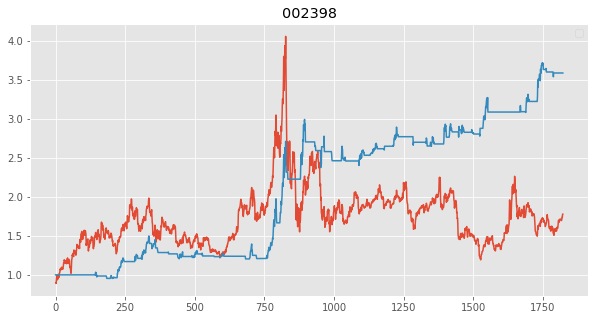

In [17]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.plot(data['stock_return'])
ax.plot(data['strategy_return'])
plt.title(code)
plt.legend()
plt.show()

#### 4.策略改进和优化思考
1.考虑成交量的配合：在锤子线后面的一根K线如果放量的话，交易信号更可信；

2.考虑跟其他形态的结合，例如锤子线后面紧跟着一根大阳线，交易信号更可信；

3.考虑和其他技术指标的结合，配合技术指标一起进行条件选股；